In [13]:
%pip install -U langsmith
%pip install --upgrade --quiet  langchain-gigachat
%pip install langchain_gigachat


  Using cached requests_toolbelt-1.0.0-py2.py3-none-any.whl.metadata (14 kB)
Using cached requests_toolbelt-1.0.0-py2.py3-none-any.whl (54 kB)



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
#import
import os
import requests
from langsmith import evaluate, Client
from langsmith.schemas import Example, Run
import json
import time

In [2]:

os.environ["LANGCHAIN_TRACING_V2"] = 'true'
os.environ["LANGCHAIN_ENDPOINT"]="https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"]="key"

### Проверка на выдачу ответа в формате JSON для GigaChat
Видно, что гигачат не справляется с поставленной задачей
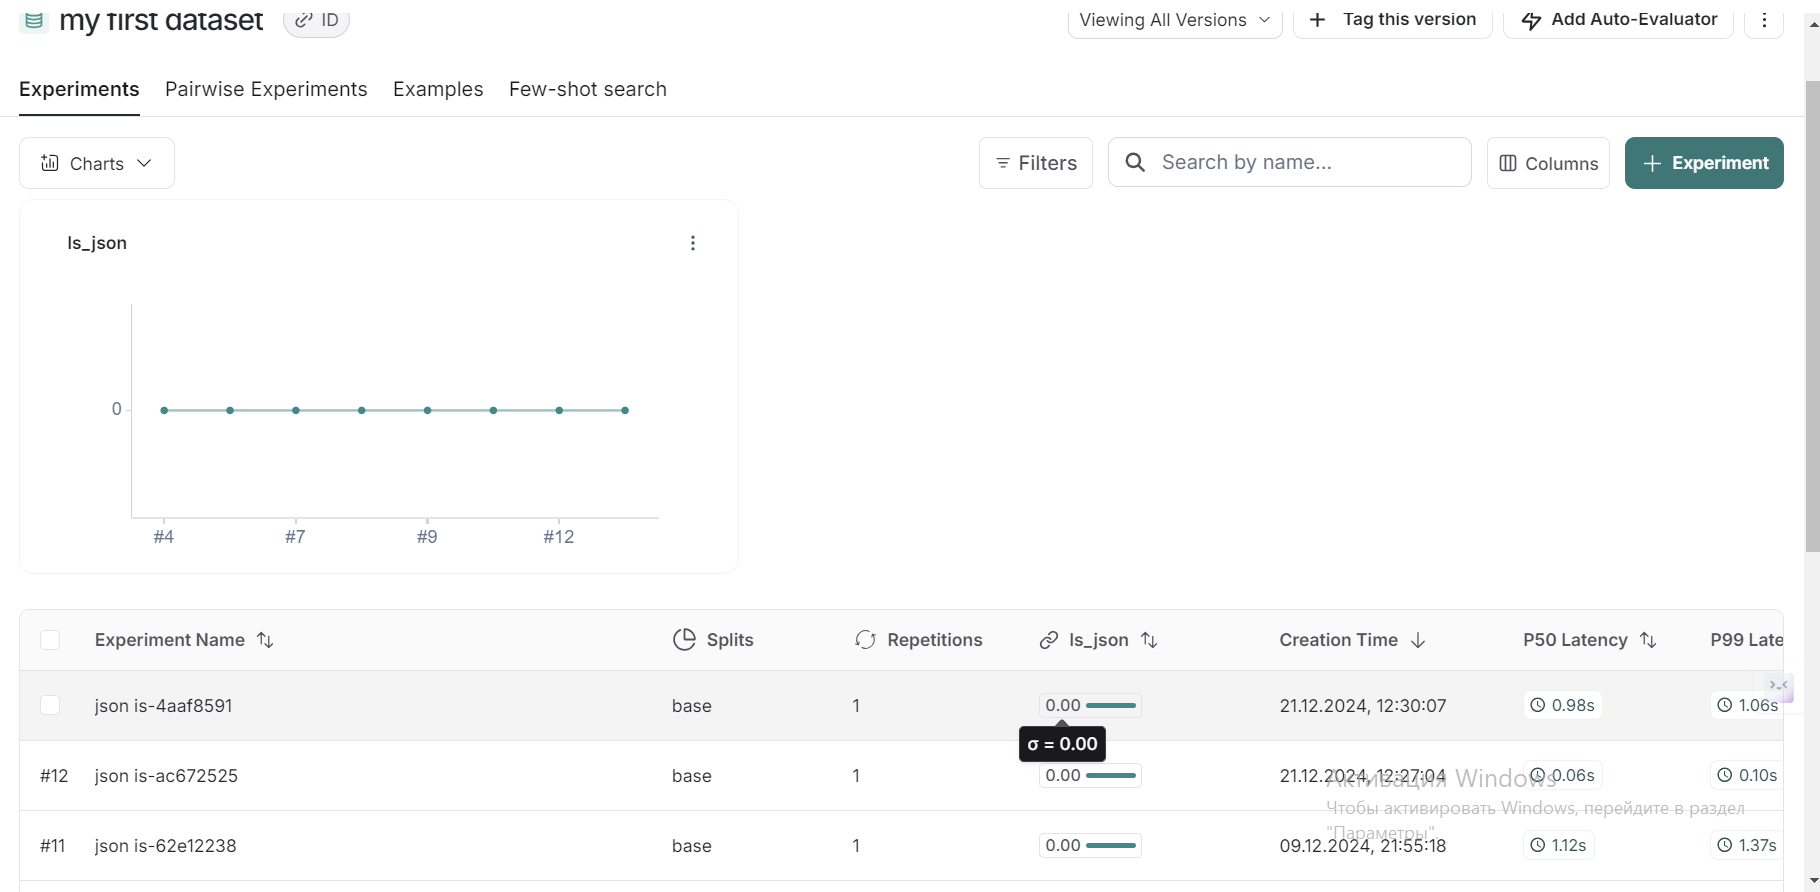

## Загрузка датасетов
 С помощью gpt4 были созданны датасеты для проверки. На их основе оцениваем работу mistral.
 Преобразуем данные для загрузки в системк

In [ ]:
input_file = 'datasets/full_dataset.json'

with open(input_file, 'r',encoding='utf-8') as file:
    data = json.load(file)

print(type(data))
print(data)

In [11]:
def json_to_jsonl(json_data, output_file):
    with open(output_file, 'w') as f:
           for key, value in json_data.items():
            good_line = True
            # Создаем объект для каждой записи
            record = {}
            #record['url'] = key
            record['question'] = value["question"]
            record["answer"] = value["answer"]
           # record["info_rag"] = value["relevant_batches_texts"]
            for k,v in record.items():
                if len(v) == 0:
                    good_line = False
            if good_line:
                # Записываем объект в формате JSONL
                f.write(json.dumps(record) + '\n')

In [12]:
json_to_jsonl(data, 'datasets/q_a_texts_url_real.jsonl')

In [5]:
import os
from mistralai import Mistral

m_api_key = 'mistral api key'
model = "mistral-large-latest"



from langsmith import evaluate, Client
from langsmith.schemas import Example, Run
import json

# 1. select dataset
client = Client()

dataset_name = 'q_a_t_u'

# 2. metrics

# is json output format
def is_json(root_run: Run, example: Example) -> dict:
    try:
        json.loads(root_run.outputs["output"])
        return True
    except:
        return False
    
# get right answer to question
def is_rigth_ans_with_batch(root_run: Run, example: Example) -> dict:
    try:
        time.sleep(4)
        mc_client = Mistral(api_key=m_api_key)
        chat_response = mc_client.chat.complete(
        model= model,
        messages = [
                    {"role": "system",
                        "content": f"""
                        You are a helpful AI assistant focused on checking ans and question.
                        Your main task is to determine whether the correct answer has been given to the question. 
                        You have a reference answer {example.outputs['answer/0']}, 
                        and here is the actual answer {root_run.outputs["output"]}. 
                        If the actual answer matches, return True;
                        otherwise, return False.
                        Return only True or only False.

                        Format as:
                        [True/False]
                     """}])

        print(chat_response.choices[0].message.content)
        if 'True' in chat_response.choices[0].message.content or 'true' in chat_response.choices[0].message.content:
            return True
        else:
            return False
    except:
        return False
    
# function - send question with batch
def simp_chat(x):
    time.sleep(4)
    m_client = Mistral(api_key=m_api_key)
    chat_response = m_client.chat.complete(
        model= model,
        messages = [
                    {"role": "system",
                        "content": """
                        You are a helpful AI assistant focused on answering questions based on provided context.
                     Your core responsibilities:

                    - Use only information from the given context.
                    - When you reference information from a source, cite it by adding the source number in square brackets at the end of the sentence (e.g., [1]).
                    - Use the source numbers as provided in the Sources section.
                    - Acknowledge limitations when context is insufficient.
                    - Highlight any contradictions in sources.
                    - Respond in the same language as the question is asked.
                    - Return right json. 
                    - Do not write text "```json ..." before {, return only {}.

                    Format your responses as:
                    {
                        "Answer": "[detailed response with sources citations in square brackets]",
                        "Sources": {
                            "[source_id1]" : "[source link]",
                            "[source_id2]" : "[source link]",
                            .....
                            "[source_idn]" : "[source link]"
                        }
                    }"""
                    },
            {
                "role": "user",
                "content": f"""Here is the relevant context:

                    {x['info_rag/0']}
                    {x['info_rag/1']}
                    {x['info_rag/2']}
                    {x['info_rag/3']},
                    {x['info_rag/4']}

                    Question: {x['question']}

                    Please provide a complete answer following the required format.""",
                                },
                            ])
    return chat_response.choices[0].message.content

# 3. Run an evaluation
evaluate(
    simp_chat,
    data=dataset_name,
    evaluators=[is_json, is_rigth_ans_with_batch],
    experiment_prefix="json is"
)

View the evaluation results for experiment: 'json is-85b2f95f' at:
https://smith.langchain.com/o/01cd58a7-eef9-4d4d-8f46-d914573d2088/datasets/8f0ca905-2760-4403-a736-0ef0fe1b8008/compare?selectedSessions=3f1e44ae-e8b5-46bb-bdcd-5eb3759a5c21




1it [00:14, 14.98s/it]

False


2it [00:29, 14.50s/it]

False


3it [00:47, 16.35s/it]

True


4it [00:59, 14.46s/it]

True


5it [01:15, 15.25s/it]

True


6it [02:23, 33.01s/it]

False


7it [02:37, 26.81s/it]

True


8it [02:51, 22.72s/it]

True


9it [03:07, 20.55s/it]

True


10it [03:40, 24.38s/it]

True


11it [04:01, 23.52s/it]

True


12it [04:24, 23.39s/it]

True


13it [04:38, 20.50s/it]

True


14it [05:02, 21.49s/it]

False


15it [05:15, 19.03s/it]

True


16it [05:34, 18.79s/it]

False


17it [05:46, 16.75s/it]

True


18it [06:01, 16.50s/it]

True


19it [06:27, 19.35s/it]

True


20it [06:53, 21.24s/it]

True


21it [07:12, 20.47s/it]

True


22it [07:27, 18.98s/it]

False


23it [07:42, 17.74s/it]

True


24it [07:57, 17.02s/it]

True


25it [08:11, 15.87s/it]

True


26it [08:26, 15.75s/it]

True


27it [08:39, 14.79s/it]

False


28it [08:56, 15.56s/it]

True


29it [09:09, 14.94s/it]

True


30it [09:24, 14.94s/it]

True


31it [09:49, 17.84s/it]

True


32it [10:05, 17.17s/it]

False


33it [12:30, 55.70s/it]

False


34it [12:48, 44.36s/it]

True


35it [13:20, 40.47s/it]

False


36it [13:33, 32.42s/it]

True


37it [13:48, 27.25s/it]

True


38it [14:10, 25.44s/it]

True


39it [14:21, 21.38s/it]

True


40it [14:39, 20.11s/it]

True


41it [14:55, 18.83s/it]

False


42it [15:10, 17.76s/it]

True


43it [15:30, 18.53s/it]

False


44it [15:56, 20.61s/it]

True


45it [16:21, 22.09s/it]

True


46it [16:32, 18.73s/it]

True


47it [16:44, 16.76s/it]

True


48it [17:03, 17.24s/it]

True


49it [17:38, 22.85s/it]

True


50it [17:52, 20.09s/it]

True


51it [18:25, 24.00s/it]

True


52it [18:52, 24.85s/it]

True


53it [19:09, 22.37s/it]

True


54it [19:22, 19.54s/it]

True


55it [19:36, 17.98s/it]

True


56it [20:08, 22.07s/it]

False


57it [20:20, 19.31s/it]

True


58it [20:33, 17.32s/it]

True


59it [20:48, 16.69s/it]

False


59it [20:49, 21.17s/it]


,inputs.url,inputs.question,inputs.info_rag/0,inputs.info_rag/1,inputs.info_rag/2,inputs.info_rag/3,inputs.info_rag/4,outputs.output,error,reference.answer/0,reference.question,feedback.is_json,feedback.is_rigth_ans_with_batch,execution_time,example_id,id
0,https://developer.mozilla.org/en-US/docs/Web/C...,What are the non-standard CSS properties prefi...,Non-standard Deprecated -moz-force-broken-imag...,,,,,"{\n ""Answer"": ""The non-standard CSS propert...",None,The non-standard CSS properties with the '-moz...,What are the non-standard CSS properties prefi...,True,False,10.110669,065593b3-30f5-47bb-b48d-36580fe44afa,c4131eac-bfd3-4a19-aa7c-fabb5baf0468
1,https://www.amalgama-lab.com/songs/v/vanotek/s...,Какова основная тема и смысл песни 'Someone' и...,The ↓ Vance Joy ↓ VIDEOCLUB ↓ Vanessa Paradis ...,когда закрываю глаза Tell me that you really w...,"Здесь, в моих любящих руках? Tell me that you ...",,,"{\n ""Answer"": ""Основная тема и смысл песни ...",None,Основная тема и смысл песни 'Someone' исполнит...,Какова основная тема и смысл песни 'Someone' и...,True,False,9.380300,0810f3dd-5a94-45dc-b0b4-2127f9931d0f,7c14d73e-a4f8-4ae9-a1b6-596971040b6e
2,https://www.history.com/topics/american-revolu...,What role did France play in the American Revo...,Skip to contentShowsThis Day In HistorySchedul...,which had begun as a civil conflict between Br...,,,,"{\n ""Answer"": ""France played a significant ...",None,France played a significant role in the Americ...,What role did France play in the American Revo...,True,True,13.690040,083fadeb-4031-4a0b-a626-052081899989,1a062b7e-7309-47d5-b21d-80cf07521d63
3,https://biodiversitylibrary.org/page/4383768,"¿Cuál es el año de publicación del volumen 49,...",BHL works best with JavaScript enabled Biodive...,"Page 1139 (Illustration) Fig 99, Page 1140 (Il...",,,,"{\n ""Answer"": ""El año de publicación del vo...",None,"El año de publicación del volumen 49, número 1...","¿Cuál es el año de publicación del volumen 49,...",True,True,6.740019,0a548549-45af-414b-9738-34f4d9268e29,e1175e38-72e6-4a68-b1c4-52f8ed0d026f
4,https://ya.ru/neurum/c/nauka-i-obrazovanie/q/m...,Что такое мезоны в контексте элементарных частиц?,Примеры ответов Нейро на вопросы из разных сфе...,,,,,"{\n ""Answer"": ""Мезоны — это элементарные ча...",None,Мезоны в контексте элементарных частиц — это с...,Что такое мезоны в контексте элементарных частиц?,True,True,11.788591,1203f35f-617e-4078-9cfc-5248b2a0c4bb,59b2d948-1755-4f23-8c40-25f48a4b8cff
5,https://mebel-v-dolgoprudnom.ru/,Какие условия доставки мебели предлагает интер...,Поздравляем вас! В нашем каталоге вы найдете с...,по которым стоит выбрать нас: ✔️ Большой ассор...,Мы готовы вам помочь! При формировании заказа ...,,,"{\n ""Answer"": ""Интернет-магазин в Долгопруд...",None,Интернет-магазин в Долгопрудном предлагает дос...,Какие условия доставки мебели предлагает интер...,True,False,62.577260,135eae63-323d-4247-8e66-842b8ba2f4b2,497d4441-e2e1-4e54-831e-db439256d0f8
6,https://ru.wiktionary.org/wiki/алгоритм,Каково значение слова 'алгоритм' и его морфоло...,Перейти к содержанию Главное меню Главное меню...,"неодушевлённое, мужской род, 2-е склонение (ти...",,,,"{\n ""Answer"": ""Значение слова 'алгоритм' — ...",None,"'Алгоритм' - это точный набор инструкций, опис...",Каково значение слова 'алгоритм' и его морфоло...,True,True,9.206538,2238b6d9-295c-4cfa-b29e-9d4fb32c4bc3,0d897e7f-b382-40a8-a640-fbbbd44b4958
7,https://www.who.int/news-room/fact-sheets/deta...,What initiatives has WHO launched to improve d...,Skip to main content Global Regions WHO Region...,the probability of dying from any one of the f...,people with diabetes often need medications to...,,,"{\n ""Answer"": ""WHO has launched several ini...",None,The WHO has launched the Global Diabetes Compa...,What initiatives has WHO launched to improve d...,True,True,9.123076,281d48ac-5a3a-4a14-8d6c-e3f8f4dbe3e3,097886ae-02a0-40ee-a3c4-34d353f9d987
8,https://www.techinsider.ru/vehicles/1668245-ne...,Что происходит

метрики(итоговый результат последннее значения на графиках + цифры внизу):
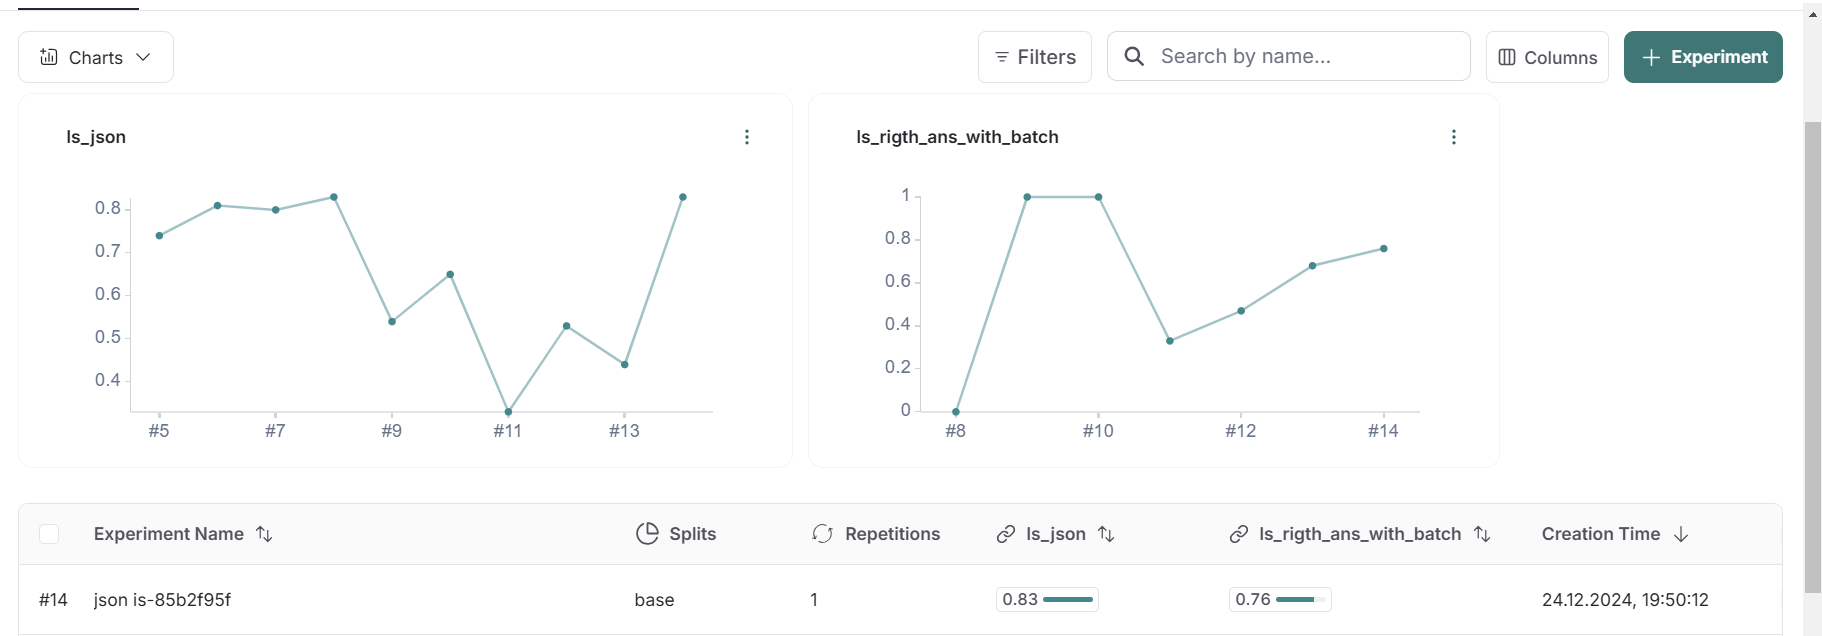